# Requirement:

External library to import

In [1]:
import sys
sys.path.insert(0, './library/')
import zipfile
import os
import time
import pymongo as pym
import pandas as pd
import folium
import numpy as np
import requests
import numba
from shapely.geometry  import Polygon, LineString, mapping, Point
import math
import geopy
import shapely
from shapely.geometry import Polygon, MultiPolygon, Point, mapping
from geopy.distance import geodesic,great_circle
from folium.plugins import FastMarkerCluster
from datetime import datetime
from geopy.distance import geodesic,great_circle
import geopandas as gpd
from shapely.geometry import shape

 # Data:

1. gtfs file of the city. 
 ->[repository of gtfs file https://transitfeeds.com/]
2. pbf file of [openstreetmap](openstreetmap.org) extract from of the city/region of interest. ->[repository of osm extract: http://download.geofabrik.de/]

# Url and paths  [**set it!**]
### mongodb settings

In [154]:
city = 'Paris'
scenario_name = 'drt' # e.g. '_drt'

# file paths and addresses to be provided:
# population data
shpPath = 'Paris/shp/pop.shp'
popCollectionName = "pop"
popField = "pop"

# Study area
# Study area defines the area in which the accessibility calaculation is executes
study_area_shp_path = 'Paris/shp/studyarea.shp'


directoryGTFS = './Paris/gtfs/'  # !! only directory of gtfs.zip file, not the path to file
gtfs_prep_toggle = True
urlMongoDb = "mongodb://localhost:27017/"  # url of the mongodb database
urlMongoDbPop = "mongodb://localhost:27017/" # url of the mongodb database for population
urlServerOsrm = 'http://localhost:5000/' # url of the osrm server of the city

# required parameters
# regarded day from gtfs file
day = '20220307'
dayName = "monday"  # name of the corresponding day

# List of starting time for computing the isochrones
# Sync to operation hours of drt, pt and conversion timeframe
timeList = list(range(7, 11, 1)) # -->[7,8,9,10,11]
# timeList = [7,10,13,16,19,22]
hStart = timeList[0]*3600 # converting to seconds

# parameters of walking distance
timeWalk = 15 * 60  # seconds
velocityWalk = 1.39  # m/s ***5km/h***
distanceS = timeWalk * velocityWalk

# Parameters thst define the resolution and extention of tesselletion and the maximum of the walking time
# grid step of the hexagonal tesselletion in kilometers
gridEdge = 1

# Set check4stops = False if cells / hexagones should be included that do not have stops within.
# Set check4stops = False for preprocessing prior to dynamic mode to gtfs convertion
# Set check4stops = True for citychrone accessibility analysis
check4stops = False


### path of the gtfs files.

In [155]:
client = pym.MongoClient(urlMongoDb)
gtfsDB = client[str('pta-' + city + '-' +scenario_name)]
popDbName = str('pta-' + city + '-' +scenario_name)

directoryGTFS = './'+ city + '/gtfs/'+ scenario_name +'/' # directory of the gtfs files.

### Settings of the date and the day for the computation of accessibility quantitites
the date must be in the interval of validity of the gtfs files, check it in the "calendar.txt" and "calendar_dates.txt" files inside the gtfs zip files.

In [156]:
from library.libConnections import printGtfsDate
printGtfsDate(directoryGTFS)

interval of validity of the gtfs files
gtfsOUT.zip file
 calendar.txt -> start_date:20220307, end_date:20220325 (first row)
gtfsOUT.zip file
 calendar_dates.txt -> date:20220303 (first row)


 ## Define url of the osrm server 

## Parameters thst define the resolution and extention of tesselletion and the maximum of the walking time

In [4]:
#grid step of the hexagonal tesselletion in kilometers
gridEdge = 1

#parameters of walking distance
timeWalk = 15 * 60 #seconds
velocityWalk = 1.39 # m/s ***5km/h***
distanceS = timeWalk * velocityWalk

# Start of the computation

### Read stops, routes, trips, calendar and calendar_dates from gtfs

### add population data

In [17]:
import geopandas as gpd
import geojson
shapefile = gpd.read_file(shpPath)
shapefile.to_file(shpPath.split('.')[0]+".geojson", driver='GeoJSON')
with open(shpPath.split('.')[0]+".geojson") as f:
    gj = geojson.load(f)
features = gj['features']
gtfsDB["pop"].drop()
gtfsDB["pop"].insert_many(features)


In [8]:
type(gj)

geojson.feature.FeatureCollection

In [9]:
from library.libStopsPoints import loadGtfsFile
listOfFile = ['stops.txt', 'routes.txt', 'trips.txt', 'calendar.txt', 'calendar_dates.txt',
              'stop_times.txt']  # , 'stop_times.txt']#, 'shapes.txt']
loadGtfsFile(gtfsDB, directoryGTFS, city, listOfFile)

removing stops  of  Paris
removing routes  of  Paris
removing trips  of  Paris
removing calendar  of  Paris
removing calendar_dates  of  Paris
removing stop_times  of  Paris
gtfsOUT.zip
stops.txt -> (53165,53165)
routes.txt -> (2190,2190)
trips.txt -> (425458,425458)
calendar.txt -> (644,644)
calendar_dates.txt -> (1436,1436)
stop_times.txt -> (9636672,9636672)


## Fill the database with the connections

In [10]:
from library.libConnections import readConnections
readConnections(gtfsDB, city, directoryGTFS, day, dayName)

number of file in calendar+calendar_dates: 1
in stops: 1

Checking the number of services active in the date selected:
file: gtfsOUT.zip 	 total number of active service (in calendar.txt): 307
number of different service_id: 1


file: gtfsOUT.zip 	 total number of active service (in calendar_dates.txt): 312
number of different service_id: 1 total number of active services found: 312
number of trips 425000
 gtfsOUT.zip
reading stop_times.txt...
readed... converting to a list
converted...
inserting to DB....55365, err 0, err_start 0, err_start_after 0
tot connections 3000582


## remove stops with no connections 
#### and add to each stop the pos field

In [ ]:
from library.libStopsPoints import removingStopsNoConnections, setPosField, removeStopsOutBorder
#removeStopsOutBorder(gtfsDB, city, 'OECD_city', ["commuting_zone", "city_core"])
removingStopsNoConnections(gtfsDB, city)
setPosField(gtfsDB, city)

In [ ]:
from library.libConnections import updateConnectionsStopName
updateConnectionsStopName(gtfsDB, city)

# Tassel with exagons

### List of all stops

In [ ]:
from library.libStopsPoints import returnStopsList
stopsList = returnStopsList(gtfsDB, city)

## Compute the box that include all stops
The edge of such box are enlarged by distanceS.

In [ ]:
from library.libStopsPoints import boundingBoxStops, mapStops
from IPython.core.display import display, HTML
display(HTML('<h1>All stops of the public transport present in the gtfs files</h1>'))
bbox = boundingBoxStops(stopsList)
mapStops(bbox, stopsList)

In [ ]:
print(bbox)

In [11]:
from library.libStudyArea import extractBoundingBoxFromShp
bbox = extractBoundingBoxFromShp(study_area_shp_path)

In [12]:
print(bbox)

[1.9894720092135625, 48.57149243921834, 2.3777057578335743, 48.924846224035896]


## Tassel the box with exagons.

In [14]:
from library.libHex import hexagonalGrid
hexBin, pointBin = hexagonalGrid(bbox, gridEdge, gtfsDB['stops'], distanceS, city, True)

In [15]:
import csv

field_names = ["point","hex","city","served","pos"]


with open('Names.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names, delimiter=';')
    writer.writeheader()
    writer.writerows(pointBin)

In [16]:
from library.libHex import insertPoints
insertPoints(pointBin, city, gtfsDB)
#print('total number of hexagons created : {0}'.format(gtfsDB['points'].find({'city':city}).count()))

In [4]:
from library.libHex import unionHexs
from IPython.core.display import display, HTML
display(HTML('<h1>First tesselletion of the area served by public transport</h1>'))
latlon = list(reversed(gtfsDB['points'].find_one({'city':city})['point']['coordinates']))
map_osm = folium.Map(location=latlon, zoom_start=9);
map_osm.choropleth(unionHexs(pointBin),  fill_color='#3288bd',fill_opacity=0.3, line_color='#3288bd',line_weight=2, line_opacity=1)
map_osm

NameError: name 'pointBin' is not defined

## Find the hex with walkingTime less than timeWalk from a stops

In [ ]:
from library.libHex import pointsServed
pointsServed(gtfsDB, stopsList, urlServerOsrm, distanceS, timeWalk, city)

In [ ]:
#print("Number of hexagons: {0}".format(gtfsDB['points'].find({'served':True, 'city':city}).count()))

## Setting field "pos" for points for performance

In [ ]:
from library.libHex import settingHexsPos
settingHexsPos(gtfsDB, city)

In [ ]:
from library.libHex import showHexs
from IPython.core.display import display, HTML
display(HTML('<h1>Tesselletion of the area served by the public transport</h1>'))
showHexs(gtfsDB, city, 10)

## Setting Population of Hexagons

In [18]:
from library.libHex import setHexsPop

if urlMongoDbPop != "" and popCollectionName != "":
    clientPop = pym.MongoClient(urlMongoDbPop)
    popDb = clientPop[popDbName]
    popCollection = popDb[popCollectionName]
    setHexsPop(gtfsDB, popCollection, popField, city)
else:
    print("Population NOT INSERTED!")

res = gtfsDB['points'].update_many({'pop':{'$exists':False}}, {'$set':{'pop':0}})
print("n° of matched hexagons with population Polygons: {0} \n \
not matched: {1} (setted to zero)".format(gtfsDB['points'].find({'pop':{'$exists':True}}).count(),
                                                                                     res.modified_count))

n° of matched hexagons with population Polygons: 1581 
 not matched: 0 (setted to zero)


<ipython-input-18-fa50f77f5142>:13: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  not matched: {1} (setted to zero)".format(gtfsDB['points'].find({'pop':{'$exists':True}}).count(),


# Adding the walking time between stops and points

In [ ]:
from libStopsPoints import computeNeigh
computeNeigh(gtfsDB, urlServerOsrm, distanceS, timeWalk,  city)

# Compute quantities and observable

TimeList is the list of starting time for computing the isochrones

In [4]:
#timeList = list(range(6,22,2))#[7,10,13,16,19,22] # List of starting time for computing the isochrones
#timeList = [7,10,13,16,19,22] # List of starting time for computing the isochrones
#hStart = timeList[0]*3600

In [5]:
timeList = list(range(7,11,1))#[7,10,13,16,19,22] # List of starting time for computing the isochrones
#timeList = [7,10,13,16,19,22] # List of starting time for computing the isochrones
hStart = timeList[0]*3600

### List of connections

In [6]:
from libConnections import makeArrayConnections
arrayCC = makeArrayConnections(gtfsDB, hStart, city)

start making connections array
done recover all cc 2989768
cenverted
Num of connection 2989768


### List of list of the points and stops neighbors

In [7]:
from libStopsPoints import listPointsStopsN 
arraySP = listPointsStopsN(gtfsDB, city)

## Compute accessibility quantities

In [10]:
listAccessibility = ['velocityScore','socialityScore', 'velocityScoreGall', 
                     'socialityScoreGall','velocityScore1h', 'socialityScore1h',
                    'timeVelocity', 'timeSociality']

In [11]:
import imp
import icsa
import libAccessibility

imp.reload(libAccessibility)
from icsa import computeAccessibilities
imp.reload(icsa)
listAccessibility = ['velocityScore','socialityScore', 'velocityScoreGall', 
                     'socialityScoreGall','velocityScore1h', 'socialityScore1h',
                    'timeVelocity', 'timeSociality']

computeIsochrone = False
if 'isochrones' in gtfsDB.collection_names():
    #gtfsDB['isochrones'].delete_many({'city':city})
    pass
for timeStart in timeList:
    timeStart *= 3600
    print( 'Time Isochrone Start: {0}'.format(timeStart/3600,))
    computeAccessibilities(city, timeStart, arrayCC, arraySP, gtfsDB, computeIsochrone, timeStart/3600 == timeList[0], listAccessibility=listAccessibility)

<ipython-input-11-8752b2a64a95>:13: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  if 'isochrones' in gtfsDB.collection_names():
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


Time Isochrone Start: 7.0


/home/sdiepolder/anaconda3/lib/python3.8/site-packages/pymongo/collection.py:1533: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://docs.mongodb.com/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)
./library/libAccessibility.py:75: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "computeVel" failed type inference due to: non-precise type pyobject
During: typing of argument at ./library/libAccessibility.py (77)

File "library/libAccessibility.py", line 77:
    def computeVel(timePReached, data):
        areaHex = data['areaHex']
        ^

  @jit()
./library/libAccessibility.py:75: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "computeVel" failed type inference due to: Cannot determine Numba type of <

/home/sdiepolder/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "computeVel" was compiled in object mode without forceobj=True, but has lifted loops.

File "library/libAccessibility.py", line 77:
    def computeVel(timePReached, data):
        areaHex = data['areaHex']
        ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "library/libAccessibility.py", line 77:
    def computeVel(timePReached, data):
        areaHex = data['areaHex']
        ^

  warnings.warn(errors.NumbaDeprecationWarning(msg,
./library/libAccessibility.py:

Time Isochrone Start: 8.0re : 5.3, Sociality Score : 514167.1, time to finish : 0.0h, 0.0 mmm


/home/sdiepolder/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/pymongo/collection.py:1533: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://docs.mongodb.com/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout

Time Isochrone Start: 9.0re : 5.4, Sociality Score : 519781.5, time to finish : 0.0h, 0.0 mmm


/home/sdiepolder/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/pymongo/collection.py:1533: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://docs.mongodb.com/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout

Time Isochrone Start: 10.0e : 5.1, Sociality Score : 502639.5, time to finish : 0.0h, 0.0 mmm


/home/sdiepolder/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/home/sdiepolder/anaconda3/lib/python3.8/site-packages/pymongo/collection.py:1533: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://docs.mongodb.com/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout

## Compute averages of the accessiblity quantities computed

In [12]:
from libStopsPoints import computeAverage
computeAverage(listAccessibility, gtfsDB, city)

# RESULTS

## maps

In [62]:
from library.libHex import reduceGeojsonInShellSubField
from IPython.core.display import display, HTML

field1 = 'velocityScore'
field2 = 'avg'
color = ['#993404', "#f16913", "#fdae6b", '#74c476', '#31a354', '#006d2c', "#6baed6", "#4292c6", "#2171b5", '#08519c', '#f768a1', '#dd3497', '#ae017e', '#49006a'];
shell = [0., 2., 4., 5, 6., 7, 8., 9, 10., 11, 12., 13, 15, 17.];
#print ("number of hexs in total", gtfsDB['points'].find({field1:{'$exists':True}, 'city':city}).count())
res = reduceGeojsonInShellSubField(list(gtfsDB['points'].find({'city':city})), field1, field2, color, shell)
#res = showMapHexRedux(city, gtfsDB['points'], field = field, shell = shell, save=True)

display(HTML('<h1>Velocity Score</h1>'))

res[1]

shell 0.0-2.0 -> 5 hexs
shell 2.0-4.0 -> 484 hexs


/home/sdiepolder/anaconda3/lib/python3.8/site-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


shell 4.0-5 -> 373 hexs
shell 5-6.0 -> 357 hexs
shell 6.0-7 -> 202 hexs
shell 7-8.0 -> 109 hexs
shell 8.0-9 -> 35 hexs
shell 9-10.0 -> 12 hexs
shell 10.0-11 -> 4 hexs


In [157]:
field1 = 'velocityScore'
field2 = 'avg'
#top = 5000000 # socialityScore
top = 20 # velocityScore
shell = list(np.linspace(0,top,int(top*10)))
color = ['#993404'] * len(shell)
res = reduceGeojsonInShellSubField(list(gtfsDB['points'].find({'city':city})), field1, field2, color, shell)

attribute = field1 + '.' + field2
res[0]['features'][0]['properties']

att = []
geometries = []
for i in range(len(res[0]['features'])):
    
    geom = res[0]['features'][i]['coordinates']
    type = res[0]['features'][i]['type']
    data = {"type": type, "coordinates": geom}
    g = shape(data)
    geometries.append(shapely.wkt.dumps(g))
    att.append((res[0]['features'][i]['properties'][attribute]))
    
gs = gpd.GeoSeries.from_wkt(geometries, crs = 4326)
df = pd.DataFrame(att,columns=[attribute])
gdf2 = gpd.GeoDataFrame(df, geometry=gs , crs = 4326)

shell 1.7085427135678393-1.8090452261306533 -> 1 hexs
shell 1.8090452261306533-1.9095477386934674 -> 2 hexs
shell 1.9095477386934674-2.0100502512562817 -> 3 hexs
shell 2.0100502512562817-2.1105527638190957 -> 5 hexs
shell 2.1105527638190957-2.21105527638191 -> 6 hexs
shell 2.21105527638191-2.311557788944724 -> 10 hexs
shell 2.311557788944724-2.412060301507538 -> 21 hexs
shell 2.412060301507538-2.512562814070352 -> 12 hexs
shell 2.512562814070352-2.613065326633166 -> 21 hexs
shell 2.613065326633166-2.71356783919598 -> 24 hexs
shell 2.71356783919598-2.814070351758794 -> 34 hexs
shell 2.814070351758794-2.9145728643216082 -> 31 hexs
shell 2.9145728643216082-3.0150753768844223 -> 34 hexs
shell 3.0150753768844223-3.1155778894472363 -> 28 hexs
shell 3.1155778894472363-3.2160804020100504 -> 24 hexs
shell 3.2160804020100504-3.3165829145728645 -> 35 hexs
shell 3.3165829145728645-3.4170854271356785 -> 31 hexs
shell 3.4170854271356785-3.5175879396984926 -> 34 hexs
shell 3.5175879396984926-3.618090

/home/sdiepolder/anaconda3/lib/python3.8/site-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


shell 4.020100502512563-4.120603015075377 -> 35 hexs
shell 4.120603015075377-4.2211055276381915 -> 29 hexs
shell 4.2211055276381915-4.3216080402010055 -> 29 hexs
shell 4.3216080402010055-4.42211055276382 -> 30 hexs
shell 4.42211055276382-4.522613065326634 -> 35 hexs
shell 4.522613065326634-4.623115577889448 -> 43 hexs
shell 4.623115577889448-4.723618090452262 -> 61 hexs
shell 4.723618090452262-4.824120603015076 -> 46 hexs
shell 4.824120603015076-4.92462311557789 -> 41 hexs
shell 4.92462311557789-5.025125628140704 -> 39 hexs
shell 5.025125628140704-5.125628140703518 -> 49 hexs
shell 5.125628140703518-5.226130653266332 -> 35 hexs
shell 5.226130653266332-5.326633165829146 -> 47 hexs
shell 5.326633165829146-5.42713567839196 -> 37 hexs
shell 5.42713567839196-5.527638190954774 -> 43 hexs
shell 5.527638190954774-5.628140703517588 -> 25 hexs
shell 5.628140703517588-5.728643216080402 -> 30 hexs
shell 5.728643216080402-5.8291457286432165 -> 33 hexs
shell 5.8291457286432165-5.9296482412060305 -> 

In [144]:
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

In [158]:
gdf.set_crs(epsg = 4326)
gdf2.set_crs(epsg = 4326)

,velocityScore.avg,geometry
0,1.758794,"MULTIPOLYGON (((2.12939 48.57100, 2.12600 48.5..."
1,1.859296,"MULTIPOLYGON (((1.99727 48.60604, 1.99388 48.6..."
2,1.959799,"MULTIPOLYGON (((1.99727 48.67613, 1.99388 48.6..."
3,2.060302,"MULTIPOLYGON (((2.02776 48.57100, 2.02437 48.5..."
4,2.160804,"MULTIPOLYGON (((1.99727 48.86304, 1.99388 48.8..."
...,...,...
76,9.597990,"MULTIPOLYGON (((2.31232 48.82799, 2.30893 48.8..."
77,9.698492,"MULTIPOLYGON (((2.35297 48.85136, 2.34958 48.8..."
78,10.100503,"MULTIPOLYGON (((2.34281 48.86304, 2.33942 48.8..."
79,10.301508,"MULTIPOLYGON (((2.32248 48.84746, 2.31910 48.8..."


In [159]:
df = gpd.read_file("Paris/shp/cps.shp", crs=2154) 

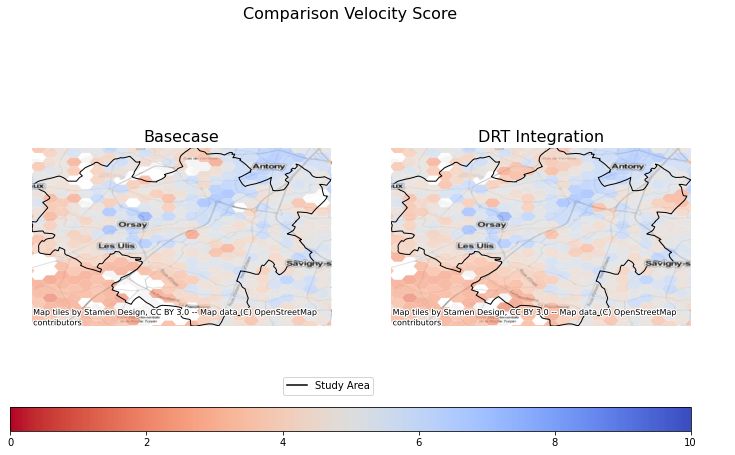

In [168]:
cmI = (1/2.54)
lim_top = 10
lim_bottom = 0
cmap = 'coolwarm_r'
alpha = 0.7
path = 'Paris/output/'+field1 + '_' +field2 +'.png'
fs = 16

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30*cmI, 17*cmI))
#
gdf.plot(ax = ax1, column=field1 + '.' +field2, legend=False, vmin=lim_bottom, vmax=lim_top, cmap=cmap, alpha = alpha)
df.plot(ax = ax1, edgecolor='black',facecolor="none", legend = False, label = 'Study Area')
cx.add_basemap(ax1, source=cx.providers.Stamen.TonerLite,crs = gdf.crs, zoom = 12)
cx.add_basemap(ax1, source=cx.providers.Stamen.TonerLabels,crs = gdf.crs, zoom = 11)
ax1.set_axis_off()
ax1.set_title('Basecase', fontsize = fs)

gdf2.plot(ax = ax2, column=field1 + '.' +field2, legend=False, vmin=lim_bottom, vmax=lim_top, cmap=cmap, alpha = alpha)
df.plot(ax = ax2, edgecolor='black',facecolor="none", legend = False, label = 'Study Area')
cx.add_basemap(ax2, source=cx.providers.Stamen.TonerLite,crs = gdf.crs, zoom = 12)
cx.add_basemap(ax2, source=cx.providers.Stamen.TonerLabels,crs = gdf.crs, zoom = 11)
ax2.set_axis_off()
ax2.set_title('DRT Integration', fontsize = fs)

fig.suptitle('Comparison Velocity Score', fontsize = fs)

xlim = ([df.total_bounds[0],  df.total_bounds[2]])
ylim = ([df.total_bounds[1],  df.total_bounds[3]])

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

mappable = cm.ScalarMappable(
    norm=mcolors.Normalize(lim_top, lim_bottom),
    cmap=cmap
)
cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.05])
cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')

# add handles for the legend
custom_lines = [
    Line2D([0], [0], color='black'),
]

# define labels for the legend
custom_labels = ['Study Area',]

# plot legend, loc defines the location
plt.legend(
    handles=custom_lines,
    labels=custom_labels,
    loc=(.4, 1.5),
    ncol=2
)

plt.savefig(path, dpi=200, bbox_inches='tight')
plt.show()

In [68]:
gdf.to_csv('Paris/output/'+field1 + '_' +field2 +'_'+ scenario_name +'.csv', sep=';', index=False)
print('Paris/output/accessibility/'+field1 + '_' +field2 +'_'+ scenario_name +'.csv')

Paris/output/accessibility/velocityScore_avg_basecase.csv


In [55]:
from library.libHex import reduceGeojsonInShellSubField
from IPython.core.display import display, HTML

field1 = 'socialityScore'
field2 = 'avg'
color = ["#000000","rgb(95, 95, 95)","rgb(180, 180, 180)","rgb(8, 48, 107)","rgb(15, 87, 159)","rgb(47, 126, 188)","rgb(109, 174, 213)","rgb(181, 212, 233)","rgb(253, 202, 148)",
"rgb(253, 176, 122)","rgb(250, 142, 93)","rgb(241, 108, 73)","rgb(224, 69, 48)","rgb(243, 105, 163)","rgb(224, 62, 152)","rgb(153, 3, 124)","rgb(73, 0, 106)"]
shell = [0, 50000, 100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1500000, 2000000,2500000, 3000000];
#print ("number of hexs in total", gtfsDB['points'].find({field1:{'$exists':True}, 'city':city}).count())
res = reduceGeojsonInShellSubField(list(gtfsDB['points'].find({'city':city})), field1, field2, color, shell)
#res = showMapHexRedux(city, gtfsDB['points'], field = field, shell = shell, save=True)

display(HTML('<h1>Sociality Score</h1>'))

res[1]

shell 0-50000 -> 1612 hexs


/home/sdiepolder/anaconda3/lib/python3.8/site-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


# Saving File
Make ZIP file containig all the public transports information needed in order to add the city to the [citychrone](www.citychrone.org) platform.

In [ ]:
newScenario=True # If True in the citychrone platform tensting new scenario on the city is allowed.
from saveData import makeZipCitychrone
if 'arrayCC' in locals():
    makeZipCitychrone(city, gtfsDB, arrayCC, newScenario=newScenario, urlServerOsrm=urlServerOsrm)
else:
    makeZipCitychrone(city, gtfsDB, newScenario=True)

# [Optional] 
# Analisys on the accessibility quantities.

## Compute average time distance from the center
Computing the average time distance from the center of the city. 
We consider two center: 
1. where the velocityScore is max
2. Where the socialityScore is max.

In [ ]:
gtfsDB['points'].find_one({'city':city})["velocityScore"].keys()
timeListSec = []
for k in gtfsDB['points'].find_one({'city':city})["velocityScore"].keys():
    try:
        timeListSec.append(int(k))
    except:
        pass
if len(timeListSec) > 10:
    timeListSec = timeListSec[2:]
print(timeListSec)

In [ ]:
from libConnections import makeArrayConnections
from libStopsPoints import listPointsStopsN 
from libHex import reduceGeojsonInShell  
from icsa import coumputeAvgTimeDistance
startPoint = gtfsDB['points'].find({'city':city},sort=[('velocityScore.avg',-1)])[0]

if 'arrayCC' not in locals():
    arrayCC = makeArrayConnections(gtfsDB, 0, city)
if 'arraySP' not in locals():
    arraySP = listPointsStopsN(gtfsDB, city)

timeDist = coumputeAvgTimeDistance(startPoint, timeListSec, arrayCC, arraySP, gtfsDB, city)
startPointLatLon = [startPoint['point']["coordinates"][1], startPoint['point']["coordinates"][0]]
for pos, tDist in enumerate(timeDist):
    pointSelectedLonLat = gtfsDB["points"].find_one({'pos':pos, "city":city})["point"]["coordinates"]
    sVelDist = geodesic(startPointLatLon,(pointSelectedLonLat[1], pointSelectedLonLat[0])).meters #dist in meter
    gtfsDB["points"].update_one({'pos':pos, 'city':city},{'$set':{'tVelDist':tDist, "sVelDist":sVelDist} })
print(timeDist)
pointsList = list(gtfsDB['points'].find({'city':city},{'pointN':0, 'stopN':0}))
res = reduceGeojsonInShell(pointsList,'tVelDist')
res[1]

In [ ]:
startPoint = gtfsDB['points'].find({'city':city},sort=[('socialityScore.avg',-1)])[0]

if 'arrayCC' not in locals():
    arrayCC = makeArrayConnections(gtfsDB, 0, city)
if 'arraySP' not in locals():
    arraySP = listPointsStopsN(gtfsDB, city)

timeDist = coumputeAvgTimeDistance(startPoint, timeListSec, arrayCC, arraySP, gtfsDB, city)
for pos, tDist in enumerate(timeDist):
    gtfsDB["points"].update_one({'pos':pos, 'city':city},{'$set':{'tSocDist':tDist}})
timeDist
pointsList = list(gtfsDB['points'].find({'city':city},{'pointN':0, 'stopN':0}))
res = reduceGeojsonInShell(pointsList,'tSocDist')
res[1]

## Analisys Exponential Decay of accessibility the quantities

### Velocity Score and Sociality score vs time distance from the center

 1. fitting function:
     $ae^{-bx}$
 2. fitting function:
     $ae^{-bx^2}$
 3. fitting function:
     $\text{maxValue} * e^{-bx^a}$

In [ ]:
from libAnalysis import fitAndPlot, expon, gauss, giveVarExpon

maxValue = gtfsDB['points'].find({'city':city}, sort=[(('velocityScore.avg',-1))])[0]["velocityScore"]["avg"]
functVarExp =  giveVarExpon(maxValue)
fitAndPlot('velocityScore','tVelDist', gtfsDB, city, expon, p0 = [12,0.0001], nameFunc = "exponential")
fitAndPlot('velocityScore','tVelDist', gtfsDB, city, gauss, p0 = [12,0.000001], nameFunc = "exponential")
fitAndPlot('velocityScore','tVelDist', gtfsDB, city, functVarExp, p0 = [1,0.0001], nameFunc = "exponential");

In [ ]:
from libAnalysis import fitAndPlot, expon, gauss, giveVarExpon

quantity = "socialityScore"
distField = "tSocDist"
maxValue = gtfsDB['points'].find({'city':city}, sort=[((quantity+'.avg',-1))])[0][quantity]["avg"]
functVarExp =  giveVarExpon(maxValue)
fitAndPlot(quantity,distField, gtfsDB, city, expon, p0 = [100000,0.0001], nameFunc = "exponential")
fitAndPlot(quantity,distField, gtfsDB, city, gauss, p0 = [100000,0.0000001], nameFunc = "gauss")
fitAndPlot(quantity,distField, gtfsDB, city, functVarExp, p0 = [1,0.001], nameFunc = "Vary Exp");